In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import calplot

from sklearn.linear_model import LassoCV, RidgeCV, LogisticRegression, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading the H2 data

data = pd.read_csv(r'C:\Users\frede\Documents\GitHub\BC2_Predict_Cancellations\data\H2.csv') 
data.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

## a) EDA

In [4]:
data.groupby('ArrivalDateYear').size()

ArrivalDateYear
2015    13682
2016    38140
2017    27508
dtype: int64

In [5]:
data.groupby('ArrivalDateMonth').size().sort_values(ascending=False)

ArrivalDateMonth
August       8983
May          8232
July         8088
June         7894
October      7605
April        7480
September    7400
March        6458
February     4965
November     4357
December     4132
January      3736
dtype: int64

In [6]:
non_metric_features = data[['CustomerType','DepositType','Meal','ReservationStatus']]

"Bookings with no assigned people can happen due to expenses in other hotel services like spa and restaurant" 
#### Coherence check

In [7]:
#the reserevations without guests will be separated
no_guests = list(data.loc[data["Adults"]
                   + data["Children"]
                   + data["Babies"]==0].index)
data.drop(data.index[no_guests], inplace=True)

In [8]:
data['Agent'].value_counts()[:10].index.tolist()

['          9',
 '       NULL',
 '          1',
 '         14',
 '          7',
 '          6',
 '         28',
 '          3',
 '          8',
 '         37']

In [9]:
data['Agent'] = data['Agent'].str.replace('NULL','0')

In [10]:
data.isnull().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        16
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
Agent                           0
Company                         0
DaysInWaitingList               0
CustomerType                    0
ADR                             0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationSta

In [11]:
data[['Children', 'Company']] = data[['Children','Company']].fillna(value=0)

Text(0.5, 1.0, 'Class Distributions \n (0: Not Canceled || 1: Canceled)')

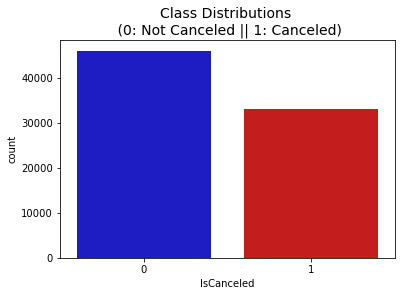

In [12]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('IsCanceled', data=data, palette=colors)
plt.title('Class Distributions \n (0: Not Canceled || 1: Canceled)', fontsize=14)

The previous visualization confirms that we don't have a heavily Imablanced Dataset

In [13]:
data.ADR.describe()

count    79163.000000
mean       105.503191
std         43.407605
min          0.000000
25%         79.200000
50%         99.960000
75%        126.000000
max       5400.000000
Name: ADR, dtype: float64

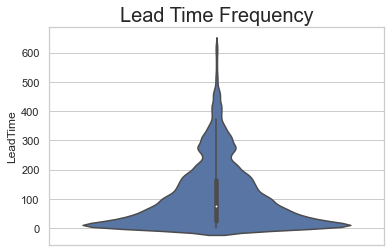

In [14]:
sns.set(style = 'whitegrid')
sns.violinplot(y=data["LeadTime"])
plt.title('Lead Time Frequency', fontsize = 20)
plt.show()

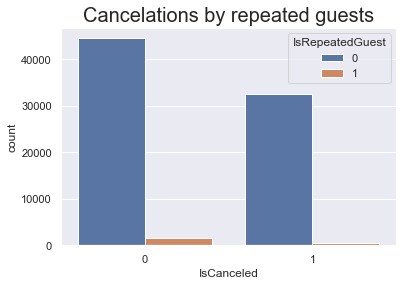

In [15]:
sns.set(style = "darkgrid")
plt.title("Cancelations by repeated guests", fontdict = {'fontsize': 20})
ax = sns.countplot(x = "IsCanceled", hue = 'IsRepeatedGuest', data = data)

Repeated guests almost never cancel their reservations

In [16]:
data['ADR']

0          0.00
1         76.50
2         68.00
3         76.50
4         76.50
          ...  
79325     96.14
79326    225.43
79327    157.71
79328    104.40
79329    151.20
Name: ADR, Length: 79163, dtype: float64

In [17]:
data["ADRpp"] = data["ADR"] / (data["Adults"] + data["Children"])
data["TotalNights"] = data["StaysInWeekendNights"] + data["StaysInWeekNights"]
not_canceled = data.loc[data['IsCanceled'] == 0]
print('From all non-canceled bookings, the average price is:',
      round(not_canceled.ADRpp.mean(),2), '€ per person and night.')

From all non-canceled bookings, the average price is: 59.27 € per person and night.


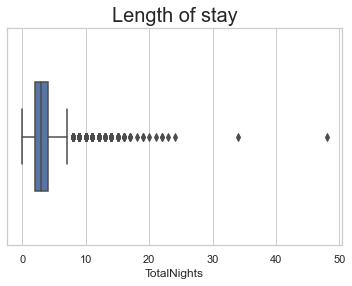

The average length of stay is : 2.9 days


In [18]:
sns.set(style = 'whitegrid')
sns.boxplot( x=not_canceled["TotalNights"], width=0.5)
plt.title('Length of stay', fontsize = 20)
plt.show()
print("The average length of stay is :", round(not_canceled['TotalNights'].mean(),1), "days")

No handles with labels found to put in legend.


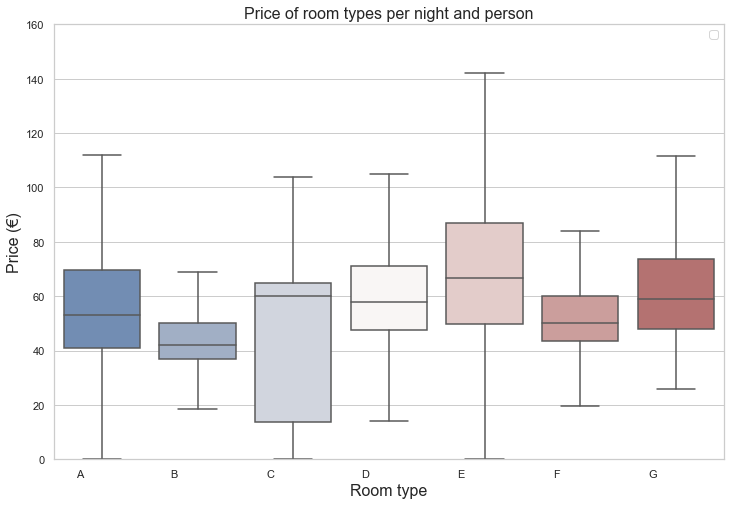

In [19]:
room_order = ["A","B","C","D","E","F","G","H","L"]

plt.figure(figsize=(12, 8))
sns.boxplot(x="ReservedRoomType",
            y="ADRpp",
            data= not_canceled.sort_values("ReservedRoomType"), 
            palette="vlag",
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price (€)", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

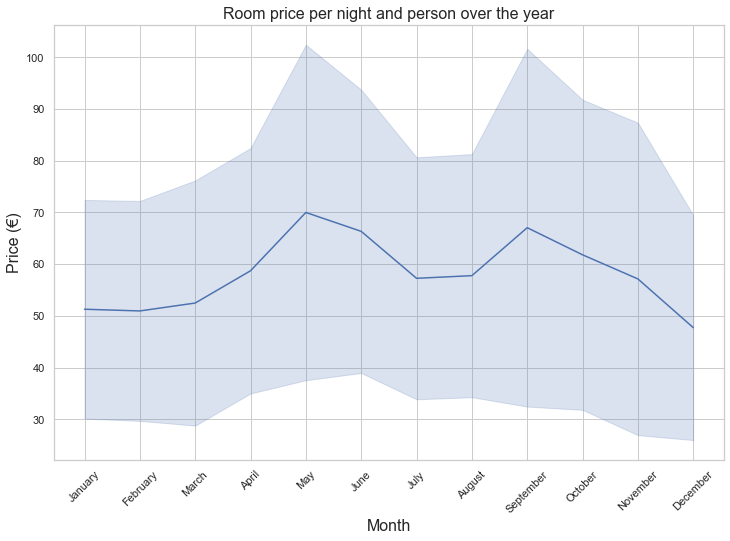

In [20]:
months_order = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

plt.figure(figsize=(12, 8))
sns.lineplot(x = pd.Categorical(not_canceled["ArrivalDateMonth"], categories=months_order, ordered=True),
             y="ADRpp", data=not_canceled, 
             ci="sd", sizes=(2.5, 2.5))
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Price (€)", fontsize=16)
plt.show()

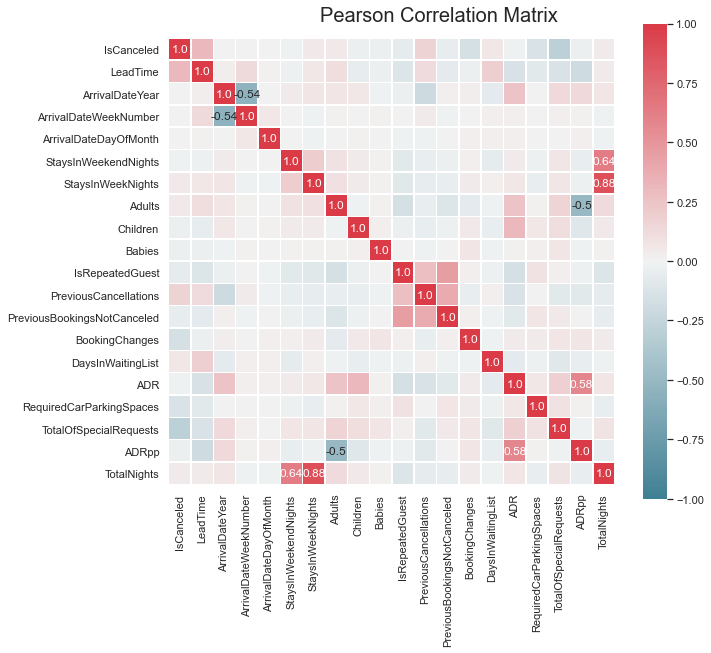

In [21]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(data.corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix", fontsize=20)

plt.show()

### Visualize the weight of the dependent variable in categorical data

In [22]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # auxiliary data for 122
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")

    plt.show()
    


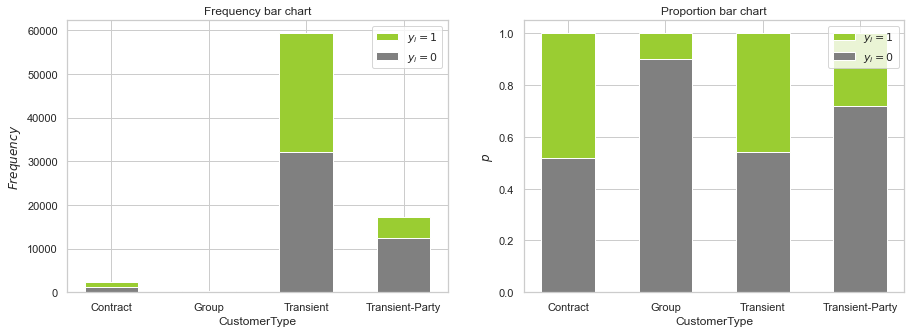

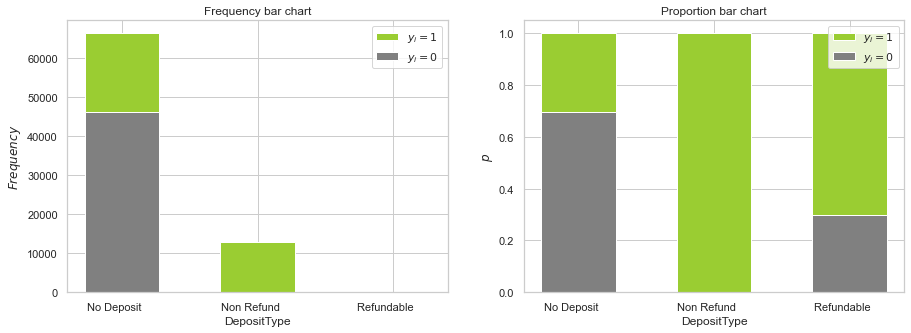

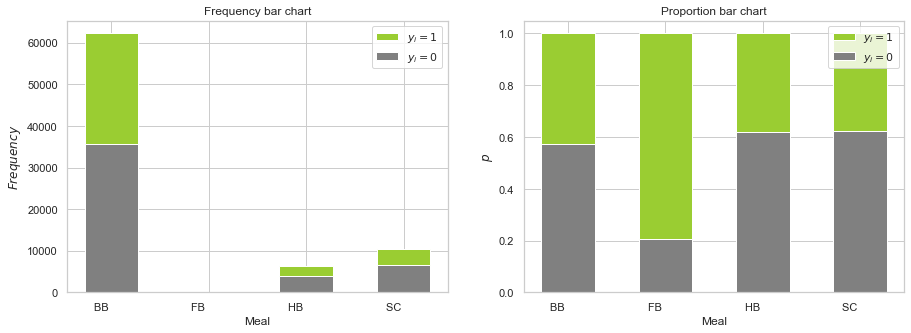

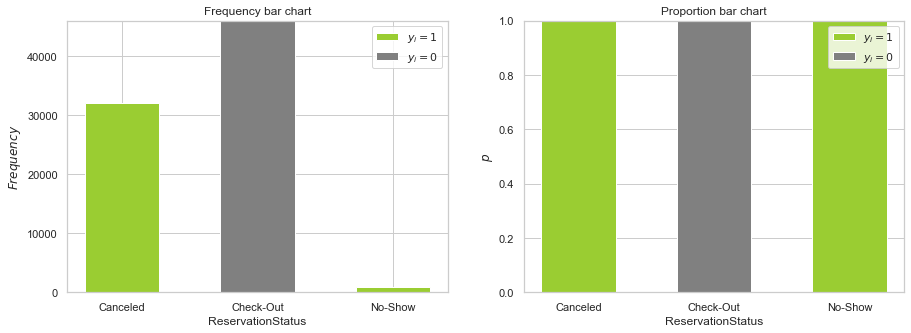

In [23]:
for var in non_metric_features:
    bar_charts_categorical(data, var , "IsCanceled")

In [24]:
# Try calheatmap!

In [25]:
canceledDates = data[data['IsCanceled']==1]
canceledDates['ReservationStatusDate'] = pd.to_datetime(canceledDates['ReservationStatusDate'])

In [26]:
canceledDates.set_index('ReservationStatusDate', inplace=True)

In [27]:
canceledDates

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ADRpp,TotalNights
ReservationStatusDate,,,,,,,,,,,,,,,,,,,,,
2015-07-01,1,88,2015,July,27,1,0,4,2,0.0,...,9,NULL,0,Transient,76.5,0,1,Canceled,38.25,4
2015-04-30,1,65,2015,July,27,1,0,4,1,0.0,...,9,NULL,0,Transient,68.0,0,1,Canceled,68.00,4
2015-06-23,1,92,2015,July,27,1,2,4,2,0.0,...,9,NULL,0,Transient,76.5,0,2,Canceled,38.25,6
2015-04-02,1,100,2015,July,27,2,0,2,2,0.0,...,9,NULL,0,Transient,76.5,0,1,Canceled,38.25,2
2015-06-25,1,79,2015,July,27,2,0,3,2,0.0,...,9,NULL,0,Transient,76.5,0,1,Canceled,38.25,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-06,1,25,2017,May,18,6,2,1,1,0.0,...,0,450,0,Transient,125.0,0,0,No-Show,125.00,3
2017-06-05,1,4,2017,June,23,5,1,0,1,0.0,...,0,238,0,Transient,65.0,0,0,Canceled,65.00,1
2017-05-31,1,7,2017,May,22,31,0,1,1,0.0,...,0,238,0,Transient,65.0,0,0,Canceled,65.00,1


In [28]:
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
# Do GRAPH cancelations percentaje per month

## b) Data Preprocessing

In [29]:
data = data.drop(columns=['ReservationStatus', 'ReservationStatusDate', 'Country','DepositType'])

### One hot encoding

In [30]:
data_ohc = data.copy()

In [31]:
data_ohc.isnull().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
Agent                          0
Company                        0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ADRpp                          0
TotalNights                    0
dtype: int64

In [32]:
##Non metric features excluding the target variable, 
#the variable created with the date of the reservation completed, 
#the ArrivalDateDayOfMonth,
#the ArrivalDate and the ReservationStatusDate
non_metric_features = ['ArrivalDateYear','ArrivalDateMonth','ArrivalDateWeekNumber',
                       'Meal','MarketSegment','DistributionChannel','IsRepeatedGuest',
                       'ReservedRoomType','AssignedRoomType','Company','Agent',
                       'CustomerType','RequiredCarParkingSpaces']

In [33]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(data_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=data_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df.head(3)

,x0_2016,x0_2017,x1_August,x1_December,x1_February,x1_January,x1_July,x1_June,x1_March,x1_May,...,x10_ 484,x10_ 495,x10_ 509,x10_ 0,x11_Group,x11_Transient,x11_Transient-Party,x12_1,x12_2,x12_3
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [34]:
# Reassigning data to contain ohc variables
data_ohc = pd.concat([data_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
data_ohc.head(3)

,IsCanceled,LeadTime,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,...,x10_ 484,x10_ 495,x10_ 509,x10_ 0,x11_Group,x11_Transient,x11_Transient-Party,x12_1,x12_2,x12_3
0,0,6,1,0,2,1,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,88,1,0,4,2,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,65,1,0,4,1,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Feature Selection 

In feature selection several different models contribute with different perspectives, this said, our methodology regarding feature selection was to create an artificial collaboration to get the best from each method.

5 different methods were used, namely correlation with our target variable, rfe, lasso CV, Ridge Regression, and a Decision Tree feature selection for both gini and entropy criterions. We used the best 30 features for all methods, except for the Ridge regression in which we used only the ones that were different than 0. Then counted the times a feature appeared for each method and we applied a threshold. This threshold allowed us to have a good feature selection and to easily manipulate the amount of features we had in our model by just lowering the threshold from minimum 2 methods or to minimum 3 methods required to appear in the final variables for the classification solution.

- Using Correlation w/ IsCanceled
- Using rfe
- Using LassoCV
- Using Ridge CV
- Using DecisionTreeClassifier

In [35]:
#Correlation w/ IsCanceled
data_ohc.corr().abs()['IsCanceled'].sort_values(ascending=False).head(20)

IsCanceled                1.000000
LeadTime                  0.308783
TotalOfSpecialRequests    0.294250
x4_Groups                 0.254515
x5_TA/TO                  0.172385
PreviousCancellations     0.166679
BookingChanges            0.150418
x11_Transient-Party       0.146542
x5_Direct                 0.145839
x4_Direct                 0.142560
x11_Transient             0.136502
x12_1                     0.133396
x8_D                      0.129681
x10_          7           0.124287
x10_         14           0.106008
x10_         28           0.104198
x9_       NULL            0.092121
x4_Online TA              0.085843
x4_Corporate              0.081313
x10_         19           0.074508
Name: IsCanceled, dtype: float64

In [36]:
top20 = list()
top20.append(data_ohc.corr().abs()['IsCanceled'].sort_values(ascending=False).head(20))

In [37]:
#RFE
target = data_ohc['IsCanceled']
datafe = data_ohc.copy().drop(['IsCanceled'], axis=1)

modelLR = LinearRegression()
rfe = RFE(estimator = modelLR, n_features_to_select = 20)
c = rfe.fit_transform(X = datafe, y = target)
modelLR.fit(X = datafe, y = target)
selected_features = pd.Series(rfe.support_, index = datafe.columns)
selected_features[selected_features.values==True]

StaysInWeekendNights    True
StaysInWeekNights       True
TotalNights             True
x5_Undefined            True
x9_         48          True
x9_        122          True
x9_        202          True
x9_        253          True
x9_        277          True
x9_        309          True
x9_        316          True
x9_        321          True
x9_        368          True
x9_        452          True
x9_        466          True
x10_         78         True
x10_        107         True
x10_        276         True
x10_        294         True
x10_        331         True
dtype: bool

In [38]:
top20.append(selected_features[selected_features.values==True].index)

In [39]:
#Lasso Regression
reg = LassoCV()
reg.fit(X = datafe, y = target)

LassoCV()

In [40]:
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(datafe,target))

coef = pd.Series(reg.coef_, index = datafe.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")  

Best alpha using built-in LassoCV: 0.073152
Best score using built-in LassoCV: 0.127836
Lasso picked 3 variables and eliminated the other 537 variables


In [41]:
top20.append(coef[coef.values!=0].index)

In [42]:
#Ridge Regression
ridge = RidgeCV()
ridge.fit(X = datafe, y = target)
print('The alpha atribute using RidgeCV: %f' %ridge.alpha_)
print('The score using RidgeCV: %f' %ridge.score(datafe,target))
coef_ridge = pd.Series(ridge.coef_, index = datafe.columns)
coef_ridge.sort_values(ascending=False).head(20)

The alpha atribute using RidgeCV: 0.100000
The score using RidgeCV: 0.393966


x9_        321      1.286460
x1_December         1.029340
x9_        452      0.986622
x1_November         0.935946
x5_Undefined        0.859068
x9_        277      0.801182
x1_October          0.799149
x10_        107     0.798511
x9_        350      0.773934
x9_        466      0.749103
x4_Groups           0.723532
x9_        428      0.712084
x9_         48      0.699008
x1_September        0.690276
x4_Offline TA/TO    0.641955
x9_        202      0.637512
x9_        309      0.636917
x10_        270     0.615859
x9_        316      0.597271
x9_        253      0.557193
dtype: float64

In [43]:
top20.append(coef_ridge.sort_values(ascending=False).head(20).index)

In [50]:
# Decision Tree Classifier
gini_importance = DecisionTreeClassifier().fit(datafe, target).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(datafe, target).feature_importances_

<AxesSubplot:xlabel='Value', ylabel='Col'>

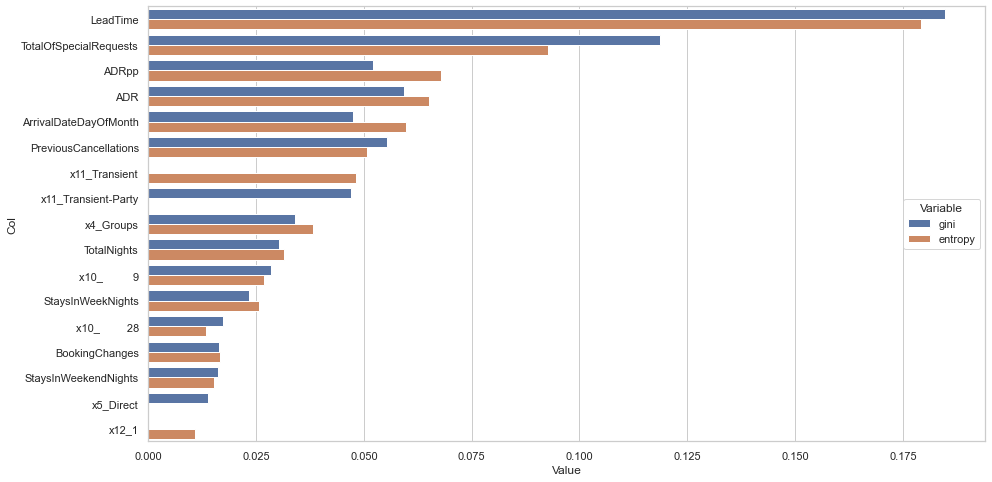

In [51]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = datafe.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy.head(30))

In [52]:
top20.append(tidy.sort_values(['Value'], ascending = False).head(30)['Col'].drop_duplicates().values)

In [53]:
onlyDT = tidy.sort_values(['Value'], ascending = False).head(30)['Col'].values.tolist()

In [54]:
series20 = pd.Series(top20) 
series20 = series20.explode().value_counts()
series20.head(3)

x5_Undefined      2
x9_         48    2
x4_Groups         2
dtype: int64

In [49]:
datafe

,LeadTime,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,...,x10_ 484,x10_ 495,x10_ 509,x10_ 0,x11_Group,x11_Transient,x11_Transient-Party,x12_1,x12_2,x12_3
0,6,1,0,2,1,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,88,1,0,4,2,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,65,1,0,4,1,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,92,1,2,4,2,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,100,2,0,2,2,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,23,30,2,5,2,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
79326,102,31,2,5,3,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
79327,34,31,2,5,2,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
79328,109,31,2,5,2,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
